# Assignment 3 Digital Signal and Image Management

## Davide Brinati, matricola: 771458

### In questo assignment si implementa uno script di classificazione basato sull'estrazione di feature neurali. 
### La rete neurale non verrà addestrata ma utilizzata solo per l'estrazione delle features. Verrà poi utilizzato un classificatore esterno (Support Vector Machine)

Selezionare due diversi problemi di classificazione:

1. Cani VS gatti
    (lo stesso dell'assignment 2, in modo da evidenziare il miglioramento in performance).
2. Problema a scelta
    (cercare e scaricare un dataset, eventualmente limitandolo in cardinalità).

In [1]:
import os
from matplotlib import pyplot as plt
from time import time
from scipy.stats import randint
import cv2 as cv

from skimage import feature
from sklearn.neighbors import KDTree
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score
import seaborn as sns

import joblib
import itertools
import random
from random import shuffle 
from pathlib import Path

from keras.preprocessing import image as kimage
from keras.applications import inception_v3
import numpy as np

C:\Users\done-\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Task 1: Cani vs Gatti

In [2]:
maximages=500
nwords=300
normalize=True

In [3]:
def image_show(num_image,label):
    for i in range(num_image):
        imgdir = Path('D:/uni/SECONDO ANNO/DIGITAL SIGNAL AND IMAGE MANAGEMENT/Esercitazione 4/Esercitazioni_04/classes/' + label)
        #print(imgdir)
        imgfile = random.choice(os.listdir(imgdir))
        #print(imgfile)
        img = cv.imread('D:/uni/SECONDO ANNO/DIGITAL SIGNAL AND IMAGE MANAGEMENT/Esercitazione 4/Esercitazioni_04/classes/'+ label +'/'+ imgfile)
        print(img.shape)
        print(label)
        plt.figure(i)
        plt.imshow(img)
        plt.title(imgfile)
    plt.show()

Esempio di 2 immagini di gatto

(375, 499, 3)
cat500
(375, 499, 3)
cat500


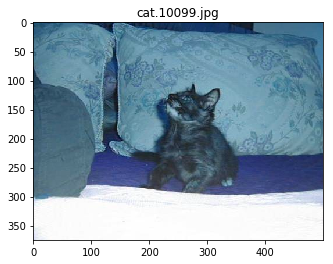

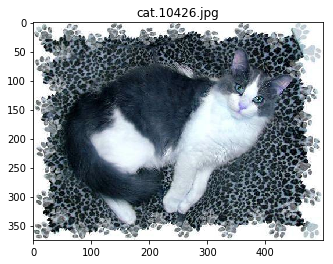

In [4]:
image_show(2, 'cat500')

Esempio di 2 immagini di cane

(500, 483, 3)
dog500
(375, 499, 3)
dog500


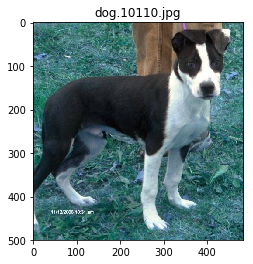

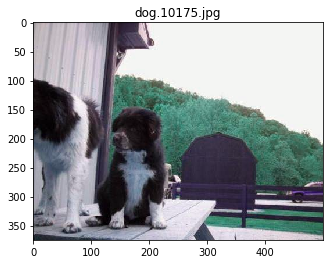

In [5]:
image_show(2, 'dog500')

In [6]:
# Feature dummy
def dummy(image):
    image = cv.resize(image, dsize=(299, 299))
    return image

# Data loader
def load_data(feature_extractor=dummy):
    base_path = 'D:/uni/SECONDO ANNO/DIGITAL SIGNAL AND IMAGE MANAGEMENT/Esercitazione 4/Esercitazioni_04/classes/'

    labels = []
    features = []

    for di,d in enumerate(sorted(os.listdir(base_path))):
        for fi,f in enumerate(sorted(os.listdir(base_path + d + '/'))):
            if f.endswith('.jpg') and fi<maximages:
                # Carica file ed estraine le features
                image = kimage.load_img(base_path + d + '/' + f, target_size=(299, 299))
                cur_features = feature_extractor(image)
                features.append(cur_features)

                # Categorie
                labels.append(di)

    # Separazione training / test set
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True, random_state=1)
    # X: features, y: labels

    return X_train, X_test, y_train, y_test

### Per l'estrazione delle features uso l'architettura InceptionV3, preallenata su imagenet

Lo strato fully-connected è stato droppato, in quanto la rete deve restituire le features estratte

In [7]:
incV3 = inception_v3.InceptionV3(input_shape=(299,299,3), weights='imagenet', include_top=False, pooling='max')
def inceptionV3_features(img):
    x = kimage.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = inception_v3.preprocess_input(x)
    f = incV3.predict(x)
    return np.array(f)

In [8]:
t0 = time()
X_train, X_test, y_train, y_test = load_data(feature_extractor=inceptionV3_features)
print("Caricamento e feature extraction in %0.3f secondi" % (time() - t0))

Caricamento e feature extraction in 99.735 secondi


### Normalizzazione delle features

In [9]:
X_train_stack = np.zeros((0,X_train[0].shape[1]), dtype=np.float32)
for t in X_train:
    X_train_stack = np.concatenate((X_train_stack, t))

In [10]:
if normalize:
    eps = 0.001
    X_train_mean = X_train_stack.mean(axis=0)
    X_train_std = X_train_stack.std(axis=0)
    X_train = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_train]
    X_test = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_test]
    
    X_train_stack = (X_train_stack - X_train_mean + eps)/(X_train_std + eps)

### Creazione del dizionario

In [11]:
dictionary = MiniBatchKMeans(n_clusters=nwords)

In [12]:
t1 = time()
dictionary.fit(X_train_stack)
print("Dizionario creato in %0.3f secondi" % (time() - t1))

Dizionario creato in 1.008 secondi


In [13]:
def bow_features(feats, dictionary):
    quantized = dictionary.predict(feats)
    t = np.bincount(quantized, minlength=nwords)
    return t

In [14]:
X_train2 = [bow_features(f, dictionary) for f in X_train]
X_test2 = [bow_features(f, dictionary) for f in X_test]

### Addestramento e hypertuning dei parametri

In [15]:
#Creo la funzione per effettuare hypertuning dei parametri
def hypertuning_rscv(mod, p_distr, nbr_iter,X,y):
    rdmsearch = RandomizedSearchCV(mod, param_distributions=p_distr,
                                  n_jobs=-1, n_iter=nbr_iter, cv=5) 
    #KFoldsCV con K=5
    start = time()
    rdmsearch.fit(X,y)
    print('hyper-tuning time : %d seconds' % (time()-start))
    start = 0
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

In [16]:
#Si inizializza la Support Vector Machine
model = SVC(class_weight='balanced', kernel='rbf')

In [17]:
#Creo il dizionario per la distribuzione dei parametri
rndmsearch_param_dist = {'C': randint(1, 1001),
                         'gamma': randint(1, 1001)}

In [18]:
#n_iter=100 --> Vengono campionati 100 parametri
model_params, model_best_score = hypertuning_rscv(model, rndmsearch_param_dist, 100, X_train2, y_train)

hyper-tuning time : 28 seconds


In [19]:
model_params['kernel'] = 'rbf'
model_params['class_weight'] = 'balanced'
print(model_params)
print('Hyper-tuned model score :')
print(model_best_score)

{'C': 556, 'gamma': 401, 'kernel': 'rbf', 'class_weight': 'balanced'}
Hyper-tuned model score :
0.8142857142857143


### Test

In [20]:
model = SVC(class_weight='balanced', kernel='rbf', C=556, gamma=401)
model.fit(X_train2, y_train)
pred= model.predict(X_test2)

In [23]:
model.score(X_test2, y_test)

0.9833333333333333

In [24]:
print("Report di classificazione:")
print(classification_report(y_test, pred))

Report di classificazione:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       149
           1       0.99      0.98      0.98       151

   micro avg       0.98      0.98      0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [21]:
def plot_confusion_matrix(cm, classes, target_names,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

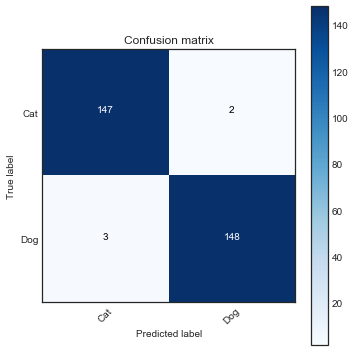

In [22]:
sns.set_style('white')
f, ax = plt.subplots(figsize= (5,5))
cfs_mtx = confusion_matrix(y_test, pred)
plot_confusion_matrix(cfs_mtx, classes=range(1), target_names= ['Cat', 'Dog'])

### Rispetto al precedente Assignment, nel quale si era implementato un script di classificazione basato su LBP, le performance sono sensibilmente migliorate, passando da un'accuracy di 0.71 a una pari a 0.983 sul test.

---------------------------------------------------------

## Task n° 2: Flowers

### 5 Classi: Daisy, Dandelion, Rose, Sunflower e Tulip

In [28]:
maximages=1000
nwords=300
normalize=True

Un esempio per ciascuna classe

In [ ]:
def image_show(num_image,label):
    for i in range(num_image):
        imgdir = Path('D:/uni/KAGGLE COMPETITIONS/flowers-recognition/flowers/' + label)
        #print(imgdir)
        imgfile = random.choice(os.listdir(imgdir))
        #print(imgfile)
        img = cv.imread('D:/uni/KAGGLE COMPETITIONS/flowers-recognition/flowers/'+ label +'/'+ imgfile)
        print(img.shape)
        print(label)
        plt.figure(i)
        plt.imshow(img)
        plt.title(imgfile)
    plt.show()

(333, 500, 3)
daisy


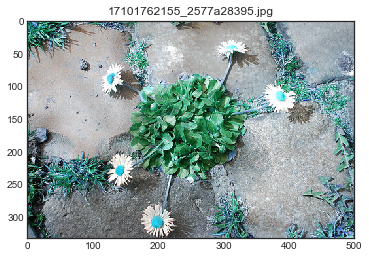

In [69]:
image_show(1, 'daisy')

(159, 240, 3)
dandelion


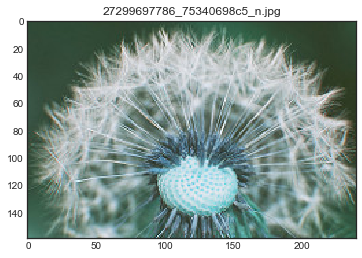

In [70]:
image_show(1, 'dandelion')

(333, 500, 3)
rose


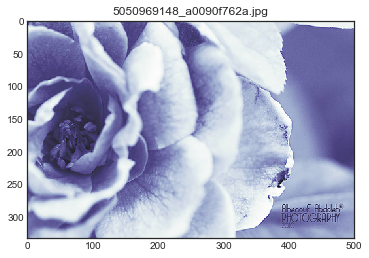

In [71]:
image_show(1, 'rose')

(240, 180, 3)
sunflower


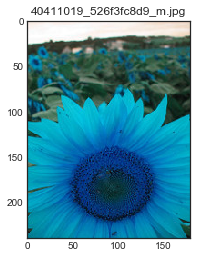

In [72]:
image_show(1, 'sunflower')

(331, 500, 3)
tulip


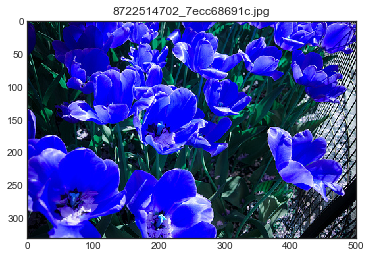

In [73]:
image_show(1, 'tulip')

### Load data

In [29]:
# Feature dummy
def dummy(image):
    image = cv.resize(image, dsize=(299, 299))
    return image

# Data loader
def load_data(feature_extractor=dummy):
    base_path = 'D:/uni/KAGGLE COMPETITIONS/flowers-recognition/flowers/'

    labels = []
    features = []

    for di,d in enumerate(sorted(os.listdir(base_path))):
        for fi,f in enumerate(sorted(os.listdir(base_path + d + '/'))):
            if f.endswith('.jpg') and fi<maximages:
                # Carica file ed estraine le features
                image = kimage.load_img(base_path + d + '/' + f, target_size=(299, 299))
                cur_features = feature_extractor(image)
                features.append(cur_features)

                # Categorie
                labels.append(di)

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True, random_state=1)

    return X_train, X_test, y_train, y_test

In [30]:
t0 = time()
X_train, X_test, y_train, y_test = load_data(feature_extractor=inceptionV3_features)
print("Caricamento e feature extraction in %0.3f secondi" % (time() - t0))

Caricamento e feature extraction in 452.056 secondi


### Normalizzo le features

In [31]:
X_train_stack = np.zeros((0,X_train[0].shape[1]), dtype=np.float32)
for t in X_train:
    X_train_stack = np.concatenate((X_train_stack, t))

In [32]:
if normalize:
    eps = 0.001
    X_train_mean = X_train_stack.mean(axis=0)
    X_train_std = X_train_stack.std(axis=0)
    X_train = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_train]
    X_test = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_test]
    
    X_train_stack = (X_train_stack - X_train_mean + eps)/(X_train_std + eps)

### Creo il Dizionario Bag of Words

In [33]:
dictionary = MiniBatchKMeans(n_clusters=nwords)

In [37]:
t1 = time()
dictionary.fit(X_train_stack)
print("Dizionario creato in %0.3f secondi" % (time() - t1))

Dizionario creato in 1.359 secondi


In [38]:
def bow_features(feats, dictionary):
    quantized = dictionary.predict(feats)
    t = np.bincount(quantized, minlength=nwords)
    return t

In [39]:
X_train2 = [bow_features(f, dictionary) for f in X_train]
X_test2 = [bow_features(f, dictionary) for f in X_test]

### Training e hyper-tuning dei parametri

In [40]:
model_params, model_best_score = hypertuning_rscv(model, rndmsearch_param_dist, 100, X_train2, y_train)

hyper-tuning time : 531 seconds


In [41]:
model_params['kernel'] = 'rbf'
model_params['class_weight'] = 'balanced'
print(model_params)
print('Hyper-tuned model score :')
print(model_best_score)

{'C': 842, 'gamma': 636, 'kernel': 'rbf', 'class_weight': 'balanced'}
Hyper-tuned model score :
0.6881900301104048


### Test

In [42]:
model = SVC(class_weight='balanced', kernel='rbf', C=842, gamma=636)
model.fit(X_train2, y_train)
pred= model.predict(X_test2)

In [44]:
accuracy_score(y_test, pred)

0.7168486739469578

In [45]:
print("Report di classificazione:")
print(classification_report(y_test, pred))

Report di classificazione:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       228
           1       0.95      0.67      0.79       310
           2       0.49      0.84      0.62       218
           3       0.67      0.64      0.65       231
           4       0.73      0.67      0.70       295

   micro avg       0.72      0.72      0.72      1282
   macro avg       0.75      0.72      0.72      1282
weighted avg       0.76      0.72      0.73      1282



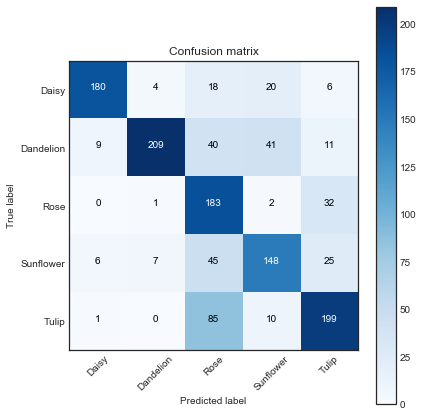

In [51]:
sns.set_style('white')
f, ax = plt.subplots(figsize= (6,6))
cfs_mtx = confusion_matrix(y_test, pred)
plot_confusion_matrix(cfs_mtx, classes=range(4), target_names= ['Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip'])